In [4]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch
from torchvision import transforms
import av
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import functools

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files
VIDEO_BASE_DIR = 'data/extracted/Chunk_1'  # Directory containing original videos

class DrivingDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get video path from CSV filename
        filename = os.path.basename(csv_file)
        name_without_ext = filename[:-4]  # Remove .csv
        
        # Split into parts and reconstruct the original path
        parts = name_without_ext.split('_')
        segment_num = parts[-1]  # Get segment number
        base_path = name_without_ext[:-len(segment_num)-1]  # Remove _4 from the end
        
        # Construct full video path
        self.video_path = os.path.join(VIDEO_BASE_DIR, base_path, segment_num, 'video.hevc')
        
        print(f"CSV file: {csv_file}")
        print(f"Video path: {self.video_path}")
        
        # Verify video exists
        if not os.path.exists(self.video_path):
            raise FileNotFoundError(f"Video file not found: {self.video_path}")
        
        # Load video frames
        print(f"Loading video frames...")
        self.frames = self.load_video_frames()
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def load_video_frames(self):
        frames = []
        container = av.open(self.video_path)
        stream = container.streams.video[0]
        stream.thread_type = "AUTO"
        
        for frame in container.decode(video=0):
            frame = frame.to_ndarray(format='rgb24')
            frame = Image.fromarray(frame)
            frame = frame.resize((400, 240), Image.Resampling.BILINEAR)
            frames.append(np.array(frame))
        
        container.close()
        return frames

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        row = self.data.iloc[idx]
        
        if self.transform:
            frame = self.transform(frame)
        
        # Get current sensor data (inputs)
        # Fix speed by removing brackets and converting to float
        speed_value = float(row['speed'].strip('[]'))
        
        current_data = torch.tensor([
            speed_value,  # Clean speed value
            row['gyro_x'], row['gyro_y'], row['gyro_z'],
            row['accel_x'], row['accel_y'], row['accel_z'],
            row['velocity_x'], row['velocity_y'], row['velocity_z'],
            row['current_steering'],  # Current steering angle as input
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

def load_dataset_parallel(csv_file):
    try:
        dataset = DrivingDataset(csv_file)
        tqdm.write(f"Successfully loaded dataset from {csv_file}")
        return dataset
    except Exception as e:
        tqdm.write(f"Error loading {csv_file}: {str(e)}")
        return None

# Create datasets for each segment in parallel
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your CPU
    datasets = list(tqdm(
        executor.map(load_dataset_parallel, csv_files),
        desc="Loading datasets",
        total=len(csv_files)
    ))
    
# Filter out None values (failed loads)
datasets = [d for d in datasets if d is not None]

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with num_workers=0 for now
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Found 7 CSV files


Loading datasets:   0%|          | 0/7 [00:00<?, ?it/s]

CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--11-17-20_4.csvCSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-03-57_6.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-03-57\6\video.hevc
Loading video frames...

Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--11-17-20\4\video.hevc
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_12.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-50-48\12\video.hevc
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_7.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-50-48\7\video.hevc
Loading video frames...


Loading datasets:  14%|█▍        | 1/7 [00:07<00:45,  7.55s/it]

Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-03-57_6.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_27.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--12-02-42\27\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_12.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--12-02-42\30\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-30--13-03-07\16\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_7.csv


Loading datasets: 100%|██████████| 7/7 [00:14<00:00,  2.11s/it]

Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_27.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv

Dataset sizes:
Total samples: 8376
Train: 5863 (70.0%)
Validation: 1256 (15.0%)
Test: 1257 (15.0%)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting future steering angles (t+200ms) from current dashcam images and sensor data.
    Based on NVIDIA's PilotNet architecture with additional sensor inputs.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()

        # Number of sensor inputs (all current data)
        # speed (1), gyro(3), accel(3), velocity(3), current_steering(1) = 11
        self.sensor_input_size = 11

        # Convolutional layers for image processing
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Sensor processing layers
        self.sensor_layers = nn.Sequential(
            nn.Linear(self.sensor_input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )

        # Placeholder for combined layers (will update in _calculate_conv_output_size)
        self.combined_layers = nn.Sequential(
            nn.Linear(1, 128),  # Placeholder
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Predicting future steering angle
        )

        # Calculate the correct input size for combined layers
        self._calculate_conv_output_size()

    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        x = torch.zeros(1, 3, 240, 400)
        x = self.conv_layers(x)
        conv_flat_size = x.numel() // x.size(0)

        # Update the first linear layer in combined_layers
        combined_input_size = conv_flat_size + 64  # 64 is from sensor_layers output
        self.combined_layers[0] = nn.Linear(combined_input_size, 128)

        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened conv features size: {conv_flat_size}")
        print(f"Combined input size: {combined_input_size}")

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        image: Tensor of shape (B, 3, H, W)
        sensor_data: Tensor of shape (B, sensor_input_size)
        Returns: Predicted steering angle at t+200ms
        """
        # Process image through CNN
        x_img = self.conv_layers(image)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten CNN features

        # Process sensor data
        x_sensor = self.sensor_layers(sensor_data)

        # Combine image and sensor features
        x_combined = torch.cat([x_img, x_sensor], dim=1)
        
        # Predict future steering angle
        future_steering = self.combined_layers(x_combined)
        return future_steering

Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

Starting training...

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 92/92 [00:03<00:00, 25.58it/s, loss=3.85e+3]


Epoch 1: Train Loss: 4202.6481, Val Loss: 2709.1074


Epoch 2/50: 100%|██████████| 92/92 [00:03<00:00, 27.75it/s, loss=4.93e+3]


Epoch 2: Train Loss: 3583.5054, Val Loss: 2289.8192


Epoch 3/50: 100%|██████████| 92/92 [00:03<00:00, 27.33it/s, loss=1.25e+3]


Epoch 3: Train Loss: 2908.2031, Val Loss: 1778.4622


Epoch 4/50: 100%|██████████| 92/92 [00:03<00:00, 27.99it/s, loss=3.3e+3] 


Epoch 4: Train Loss: 2119.8205, Val Loss: 849.7513


Epoch 5/50: 100%|██████████| 92/92 [00:03<00:00, 28.67it/s, loss=1.8e+3] 


Epoch 5: Train Loss: 1420.2125, Val Loss: 653.7080


Epoch 6/50: 100%|██████████| 92/92 [00:03<00:00, 28.60it/s, loss=451]    


Epoch 6: Train Loss: 1207.9435, Val Loss: 392.0553


Epoch 7/50: 100%|██████████| 92/92 [00:03<00:00, 27.88it/s, loss=3.01e+3]


Epoch 7: Train Loss: 927.6108, Val Loss: 315.9080


Epoch 8/50: 100%|██████████| 92/92 [00:03<00:00, 27.86it/s, loss=2.29e+3]


Epoch 8: Train Loss: 695.1955, Val Loss: 243.9518


Epoch 9/50: 100%|██████████| 92/92 [00:03<00:00, 28.50it/s, loss=1.09e+3]


Epoch 9: Train Loss: 776.7370, Val Loss: 213.6726


Epoch 10/50: 100%|██████████| 92/92 [00:03<00:00, 28.68it/s, loss=1.24e+3]


Epoch 10: Train Loss: 638.8345, Val Loss: 131.3060


Epoch 11/50: 100%|██████████| 92/92 [00:03<00:00, 28.74it/s, loss=3.52e+3]


Epoch 11: Train Loss: 587.5367, Val Loss: 83.7650


Epoch 12/50: 100%|██████████| 92/92 [00:03<00:00, 28.67it/s, loss=96.8]   


Epoch 12: Train Loss: 536.3345, Val Loss: 78.0925


Epoch 13/50: 100%|██████████| 92/92 [00:03<00:00, 28.56it/s, loss=446]    


Epoch 13: Train Loss: 528.7997, Val Loss: 73.0064


Epoch 14/50: 100%|██████████| 92/92 [00:03<00:00, 28.75it/s, loss=210]    


Epoch 14: Train Loss: 479.1518, Val Loss: 75.5218


Epoch 15/50: 100%|██████████| 92/92 [00:03<00:00, 28.56it/s, loss=987]    


Epoch 15: Train Loss: 464.3585, Val Loss: 82.4659


Epoch 16/50: 100%|██████████| 92/92 [00:03<00:00, 28.04it/s, loss=727]    


Epoch 16: Train Loss: 384.5871, Val Loss: 142.4558


Epoch 17/50: 100%|██████████| 92/92 [00:03<00:00, 28.68it/s, loss=121]    


Epoch 17: Train Loss: 387.0459, Val Loss: 152.3595


Epoch 18/50: 100%|██████████| 92/92 [00:03<00:00, 28.42it/s, loss=186]    


Epoch 18: Train Loss: 377.4657, Val Loss: 234.5984


Epoch 19/50: 100%|██████████| 92/92 [00:03<00:00, 28.44it/s, loss=201]    


Epoch 19: Train Loss: 361.7008, Val Loss: 95.2216


Epoch 20/50: 100%|██████████| 92/92 [00:03<00:00, 28.73it/s, loss=289]    


Epoch 20: Train Loss: 323.3828, Val Loss: 110.5394


Epoch 21/50: 100%|██████████| 92/92 [00:03<00:00, 28.48it/s, loss=1.21e+3]


Epoch 21: Train Loss: 358.3168, Val Loss: 62.7518


Epoch 22/50: 100%|██████████| 92/92 [00:03<00:00, 28.46it/s, loss=189]    


Epoch 22: Train Loss: 351.4910, Val Loss: 65.5156


Epoch 23/50: 100%|██████████| 92/92 [00:03<00:00, 28.46it/s, loss=81.2]   


Epoch 23: Train Loss: 321.5116, Val Loss: 86.0643


Epoch 24/50: 100%|██████████| 92/92 [00:03<00:00, 27.87it/s, loss=285]    


Epoch 24: Train Loss: 325.2178, Val Loss: 77.3988


Epoch 25/50: 100%|██████████| 92/92 [00:03<00:00, 28.85it/s, loss=270] 


Epoch 25: Train Loss: 281.4899, Val Loss: 129.7850


Epoch 26/50: 100%|██████████| 92/92 [00:03<00:00, 28.76it/s, loss=172]   


Epoch 26: Train Loss: 302.3093, Val Loss: 118.0868


Epoch 27/50: 100%|██████████| 92/92 [00:03<00:00, 28.71it/s, loss=144] 


Epoch 27: Train Loss: 295.4572, Val Loss: 53.1495


Epoch 28/50: 100%|██████████| 92/92 [00:03<00:00, 28.51it/s, loss=354]    


Epoch 28: Train Loss: 315.0120, Val Loss: 69.2240


Epoch 29/50: 100%|██████████| 92/92 [00:03<00:00, 28.71it/s, loss=1.18e+3]


Epoch 29: Train Loss: 273.9352, Val Loss: 163.9158


Epoch 30/50: 100%|██████████| 92/92 [00:03<00:00, 28.76it/s, loss=456] 


Epoch 30: Train Loss: 270.6482, Val Loss: 92.2971


Epoch 31/50: 100%|██████████| 92/92 [00:03<00:00, 28.68it/s, loss=1.25e+3]


Epoch 31: Train Loss: 305.7984, Val Loss: 139.2136


Epoch 32/50: 100%|██████████| 92/92 [00:03<00:00, 27.83it/s, loss=555]    


Epoch 32: Train Loss: 274.3974, Val Loss: 235.2770


Epoch 33/50: 100%|██████████| 92/92 [00:03<00:00, 28.59it/s, loss=631]


Epoch 33: Train Loss: 261.7390, Val Loss: 120.2473


Epoch 34/50: 100%|██████████| 92/92 [00:03<00:00, 28.78it/s, loss=356]    


Epoch 34: Train Loss: 277.2277, Val Loss: 73.1931


Epoch 35/50: 100%|██████████| 92/92 [00:03<00:00, 28.57it/s, loss=228]    


Epoch 35: Train Loss: 279.9652, Val Loss: 112.8323
Early stopping triggered at epoch 35


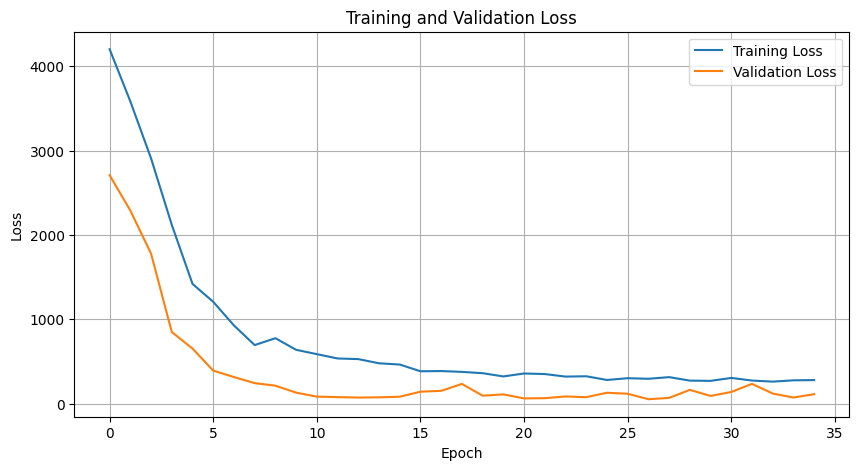


Model saved to 'steering_model.pth'

Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 146.0811 degrees²
MAE: 5.0975 degrees
Predictions within 1°: 33.6%
Predictions within 3°: 70.9%
Predictions within 5°: 83.6%


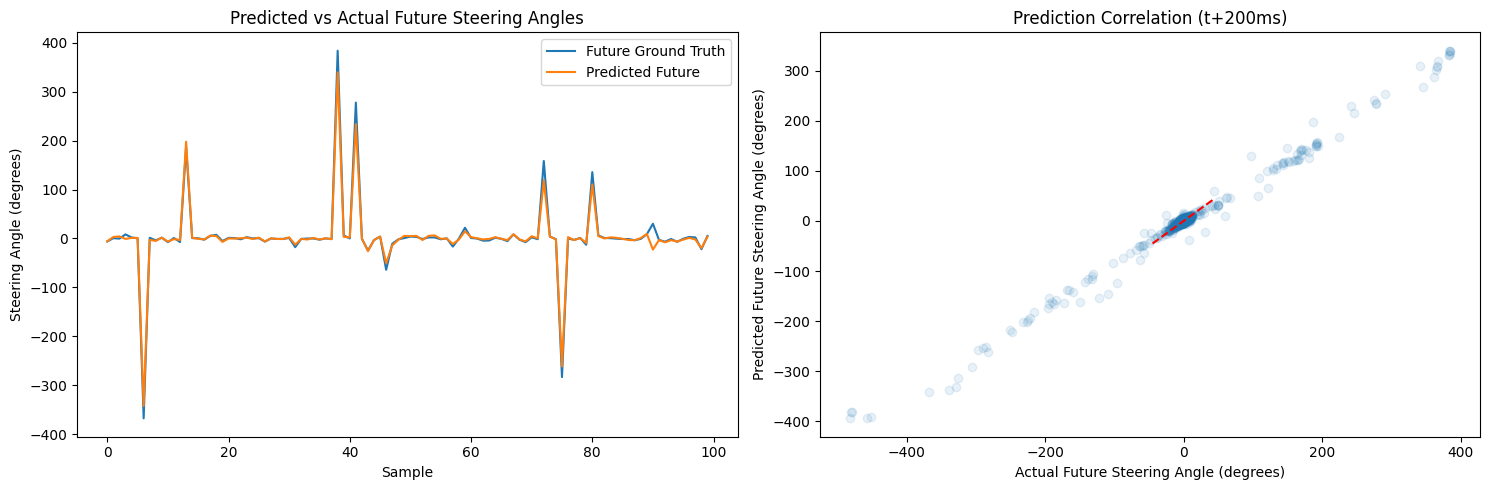


Visualizing some predictions...


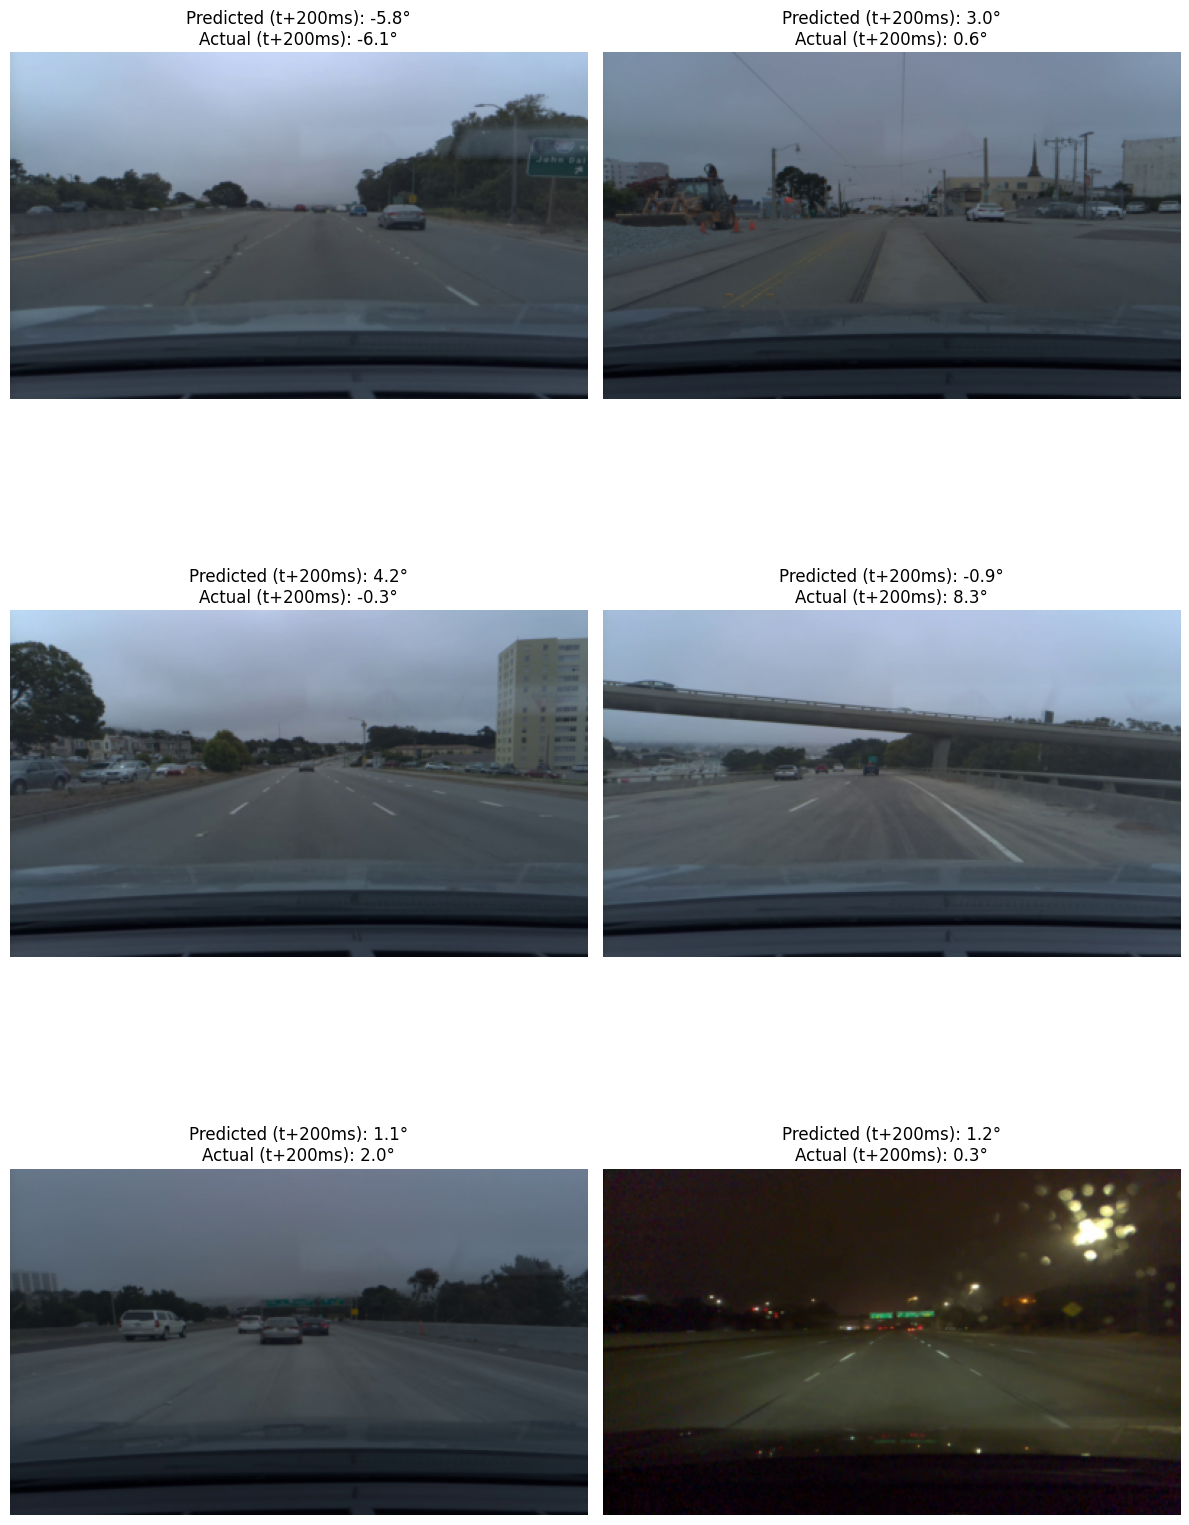

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Future Ground Truth')
    plt.plot(all_preds[:100], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

# Initialize and train
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_CNN.pth')
print("\nModel saved to 'v4_CNN.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)